# Procurement KPI Analysis & Predictive Modeling

**Dataset:** `Procurement KPI Analysis Dataset.csv`
**Source:** Provided dataset capturing procurement operations (Kaggle).
**Time Period:** Primarily 2022-2023 based on Order Dates.

**Objective:**
1.  Perform an **in-depth and creative Exploratory Data Analysis (EDA)** focusing on key procurement KPIs: Cost Savings, Supplier Performance (On-Time Delivery, Defect Rates, Compliance), Item Category Trends, and Order Status insights.
2.  Engineer relevant features and KPIs from the raw data.
3.  Develop a **high-accuracy machine learning model** to predict a key outcome (e.g., Compliance Status) and critically evaluate its performance and drivers.

**Key Areas of Focus:**
*   Cost Optimization & Negotiation Effectiveness
*   Supplier Reliability & Risk Assessment (Delivery Performance, Quality)
*   Compliance Monitoring
*   Identifying Trends and Patterns

**Columns:**
*   `PO_ID`: Purchase Order Identifier.
*   `Supplier`: Vendor name (anonymized).
*   `Order_Date`: Date the PO was placed.
*   `Delivery_Date`: Date the order was delivered. (Contains NaNs)
*   `Item_Category`: Category of the procured item.
*   `Order_Status`: Current status of the PO (Delivered, Pending, Cancelled, Partially Delivered).
*   `Quantity`: Number of units ordered.
*   `Unit_Price`: Original price per unit before negotiation.
*   `Negotiated_Price`: Final price per unit after negotiation.
*   `Defective_Units`: Number of defective units received. (Contains NaNs)
*   `Compliance`: Binary flag indicating compliance (Yes/No).

#  About the Author

**👤 Name:** Muhammad Umer  
**🔗 LinkedIn:** [https://www.linkedin.com/in/therealumerhayat/](https://www.linkedin.com/in/therealumerhayat/)  
**📧 Gmail:** umerhayat282@gmail.com  
**📞 Contact Number:** +92 302 9854427 / +92 317 6239577

***

## 1. Setup: Importing Libraries

Import necessary libraries for data manipulation, visualization, and machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

# Data processing & modeling
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Settings
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format) # Format floats for readability

____

## 2. Data Loading and Initial Inspection

Load the dataset and perform preliminary checks.

In [3]:
# Load the dataset
file_path = r'C:\Users\abc\Downloads\Procurement KPI Analysis Dataset.csv'
try:
    df_raw = pd.read_csv(file_path)
    print(f"Dataset loaded successfully. Shape: {df_raw.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    raise SystemExit("Dataset file required.")

# Display the first few rows
print("\n--- First 5 Rows ---")
print(df_raw.head())

# Display basic information
print("\n--- Data Info ---")
df_raw.info()

# Display descriptive statistics
print("\n--- Descriptive Statistics (Initial) ---")
print(df_raw.describe())

# Check for missing values
print("\n--- Missing Value Counts ---")
print(df_raw.isnull().sum())

Dataset loaded successfully. Shape: (777, 11)

--- First 5 Rows ---
      PO_ID         Supplier  Order_Date Delivery_Date    Item_Category  \
0  PO-00001        Alpha_Inc  2023-10-17    2023-10-25  Office Supplies   
1  PO-00002  Delta_Logistics  2022-04-25    2022-05-05  Office Supplies   
2  PO-00003         Gamma_Co  2022-01-26    2022-02-15              MRO   
3  PO-00004    Beta_Supplies  2022-10-09    2022-10-28        Packaging   
4  PO-00005  Delta_Logistics  2022-09-08    2022-09-20    Raw Materials   

  Order_Status  Quantity  Unit_Price  Negotiated_Price  Defective_Units  \
0    Cancelled      1176       20.13             17.81              NaN   
1    Delivered      1509       39.32             37.34           235.00   
2    Delivered       910       95.51             92.26            41.00   
3    Delivered      1344       99.85             95.52           112.00   
4    Delivered      1180       64.07             60.53           171.00   

  Compliance  
0        Yes  


**Initial Observations:**

*   The dataset has 777 rows and 11 columns.
*   `Delivery_Date` has 87 missing values. This will impact lead time calculations.
*   `Defective_Units` has 136 missing values. We'll assume NaN means 0 defects initially.
*   `Negotiated_Price` has 1 missing value - this needs addressing.
*   `Order_Date` and `Delivery_Date` are currently objects and need conversion to datetime.
*   `Compliance` is the target variable for prediction (object type).

----

## 3. Data Cleaning and Preprocessing

Handle missing values, correct data types, and standardize column names.

In [4]:
# Create a copy
df = df_raw.copy()

# --- 1. Standardize Column Names ---
df.columns = df.columns.str.lower().str.replace(' ', '_', regex=False)
print("--- Standardized Column Names ---")
print(df.columns.tolist())

# --- 2. Handle Data Types ---
# Convert date columns to datetime
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['delivery_date'] = pd.to_datetime(df['delivery_date'], errors='coerce')
print("\nConverted date columns to datetime.")

# Verify date conversion
print(df[['order_date', 'delivery_date']].dtypes)

# --- 3. Handle Missing Values ---
# Fill missing Defective_Units with 0 (assuming NaN means no defects reported)
df['defective_units'].fillna(0, inplace=True)
print(f"\nFilled missing 'defective_units' with 0. Remaining NaNs: {df['defective_units'].isnull().sum()}")

# Handle missing Negotiated_Price. Strategy: Impute with the Unit_Price for that row (assuming no negotiation occurred or wasn't recorded).
missing_negotiated_idx = df[df['negotiated_price'].isnull()].index
if not missing_negotiated_idx.empty:
    print(f"\nFound {len(missing_negotiated_idx)} missing 'negotiated_price'. Imputing with 'unit_price'.")
    df.loc[missing_negotiated_idx, 'negotiated_price'] = df.loc[missing_negotiated_idx, 'unit_price']
print(f"Remaining NaNs in 'negotiated_price': {df['negotiated_price'].isnull().sum()}")

# Delivery_Date NaNs will be handled during feature engineering (lead time calculation).

# --- 4. Verify Data Integrity (Optional Checks) ---
# Check if negotiated price is ever higher than unit price (shouldn't happen)
price_errors = df[df['negotiated_price'] > df['unit_price']].shape[0]
if price_errors > 0:
    print(f"\nWarning: Found {price_errors} rows where negotiated_price > unit_price.")
else:
    print("\nData Integrity Check: No rows found where negotiated_price > unit_price.")

# Check for negative quantities or prices
negative_values = df[(df['quantity'] < 0) | (df['unit_price'] < 0) | (df['negotiated_price'] < 0) | (df['defective_units'] < 0)].shape[0]
if negative_values > 0:
    print(f"\nWarning: Found {negative_values} rows with negative quantity/price/defects.")
else:
    print("Data Integrity Check: No negative values found in quantity, prices, or defects.")


# Display info after cleaning
print("\n--- Data Info After Cleaning ---")
df.info()

# Display cleaned data sample
print("\n--- Cleaned Data Sample ---")
print(df.head())

--- Standardized Column Names ---
['po_id', 'supplier', 'order_date', 'delivery_date', 'item_category', 'order_status', 'quantity', 'unit_price', 'negotiated_price', 'defective_units', 'compliance']

Converted date columns to datetime.
order_date       datetime64[ns]
delivery_date    datetime64[ns]
dtype: object

Filled missing 'defective_units' with 0. Remaining NaNs: 0
Remaining NaNs in 'negotiated_price': 0

Data Integrity Check: No rows found where negotiated_price > unit_price.
Data Integrity Check: No negative values found in quantity, prices, or defects.

--- Data Info After Cleaning ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   po_id             777 non-null    object        
 1   supplier          777 non-null    object        
 2   order_date        777 non-null    datetime64[ns]
 3   delivery_date     

**Cleaning Summary:**

*   Column names standardized.
*   Date columns converted to datetime.
*   Missing `defective_units` filled with 0.
*   Missing `negotiated_price` imputed using `unit_price`.
*   Basic data integrity checks performed.
*   Missing `delivery_date` values remain and will be handled in feature engineering.

___

## 4. Feature Engineering: Deriving KPIs

Create new features and Key Performance Indicators (KPIs) from the existing data to enable deeper analysis.

In [5]:
# --- 1. Calculate Lead Time ---
# Difference between delivery and order date in days
# NaT (Not a Time) will result if delivery_date is NaN
df['lead_time_days'] = (df['delivery_date'] - df['order_date']).dt.days
print("\n--- Lead Time Calculation ---")
print(f"Lead time calculated. Min: {df['lead_time_days'].min()}, Max: {df['lead_time_days'].max()}, Mean: {df['lead_time_days'].mean():.2f}")
print(f"Number of POs with missing lead time (due to missing delivery_date): {df['lead_time_days'].isnull().sum()}")

# --- 2. Calculate Costs and Savings ---
df['total_value_unit'] = df['quantity'] * df['unit_price']
df['total_value_negotiated'] = df['quantity'] * df['negotiated_price']
df['cost_savings'] = df['total_value_unit'] - df['total_value_negotiated']

# Calculate Savings Percentage (handle potential division by zero if unit_price is 0)
df['cost_savings_perc'] = np.where(
    df['unit_price'] > 0,
    ((df['unit_price'] - df['negotiated_price']) / df['unit_price']) * 100,
    0  # Assign 0% savings if unit price is 0 or less
)
# Ensure savings aren't negative due to potential data errors handled earlier
df['cost_savings'] = df['cost_savings'].clip(lower=0)
df['cost_savings_perc'] = df['cost_savings_perc'].clip(lower=0)

print("\n--- Cost & Savings Calculation ---")
print(f"Total Cost Savings across all POs: ${df['cost_savings'].sum():,.2f}")
print(f"Average Cost Savings Percentage: {df['cost_savings_perc'].mean():.2f}%")

# --- 3. Calculate Defect Rate ---
# Percentage of defective units relative to quantity ordered
# Handle potential division by zero if quantity is 0
df['defect_rate_perc'] = np.where(
    df['quantity'] > 0,
    (df['defective_units'] / df['quantity']) * 100,
    0 # Assign 0% defect rate if quantity is 0
)
print("\n--- Defect Rate Calculation ---")
print(f"Average Defect Rate: {df['defect_rate_perc'].mean():.2f}%")
print(f"Max Defect Rate: {df['defect_rate_perc'].max():.2f}%")

# --- 4. Extract Time Features ---
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['order_quarter'] = df['order_date'].dt.to_period('Q') # Quarter object
df['order_year_month'] = df['order_date'].dt.to_period('M') # Year-Month object

print("\nExtracted Year, Month, Quarter from Order Date.")

# --- 5. Define On-Time Delivery Status (Example Heuristic) ---
# This requires a definition of 'on-time'. Let's use a threshold based on typical lead times,
# or analyze lead times by category/supplier first.
# For now, let's create a flag for whether delivery occurred *at all* based on non-NaN delivery_date
df['delivery_occurred'] = df['delivery_date'].notna()

# We can also analyze lead times relative to a benchmark later in EDA.
# Example: Calculate median lead time per item category
# median_lead_times = df.groupby('item_category')['lead_time_days'].median()
# df['median_lead_time_category'] = df['item_category'].map(median_lead_times)
# df['is_late'] = df['lead_time_days'] > df['median_lead_time_category']

print("\nCreated 'delivery_occurred' flag.")

# Display dataframe with new features
print("\n--- DataFrame with Engineered Features (Sample) ---")
print(df.head())


--- Lead Time Calculation ---
Lead time calculated. Min: -5.0, Max: 20.0, Mean: 10.78
Number of POs with missing lead time (due to missing delivery_date): 87

--- Cost & Savings Calculation ---
Total Cost Savings across all POs: $3,931,126.47
Average Cost Savings Percentage: 7.97%

--- Defect Rate Calculation ---
Average Defect Rate: 5.78%
Max Defect Rate: 35.71%



Extracted Year, Month, Quarter from Order Date.

Created 'delivery_occurred' flag.

--- DataFrame with Engineered Features (Sample) ---
      po_id         supplier order_date delivery_date    item_category  \
0  PO-00001        Alpha_Inc 2023-10-17    2023-10-25  Office Supplies   
1  PO-00002  Delta_Logistics 2022-04-25    2022-05-05  Office Supplies   
2  PO-00003         Gamma_Co 2022-01-26    2022-02-15              MRO   
3  PO-00004    Beta_Supplies 2022-10-09    2022-10-28        Packaging   
4  PO-00005  Delta_Logistics 2022-09-08    2022-09-20    Raw Materials   

  order_status  quantity  unit_price  negotiated_price  defective_units  \
0    Cancelled      1176       20.13             17.81             0.00   
1    Delivered      1509       39.32             37.34           235.00   
2    Delivered       910       95.51             92.26            41.00   
3    Delivered      1344       99.85             95.52           112.00   
4    Delivered      1180       64.07       

**Feature Engineering Summary:**

*   Calculated `lead_time_days`. Noted missing values where `delivery_date` was absent.
*   Calculated total costs (`total_value_unit`, `total_value_negotiated`), `cost_savings`, and `cost_savings_perc`.
*   Calculated `defect_rate_perc`.
*   Extracted time-based features (`order_year`, `order_month`, `order_quarter`, `order_year_month`).
*   Created a basic `delivery_occurred` flag. More sophisticated on-time analysis can be done in EDA.

----

## 5. Exploratory Data Analysis (EDA) - Unlocking Insights

Analyze the data visually and statistically, focusing on the engineered KPIs and relationships relevant to procurement.

### 5.1. Overall KPI Distributions

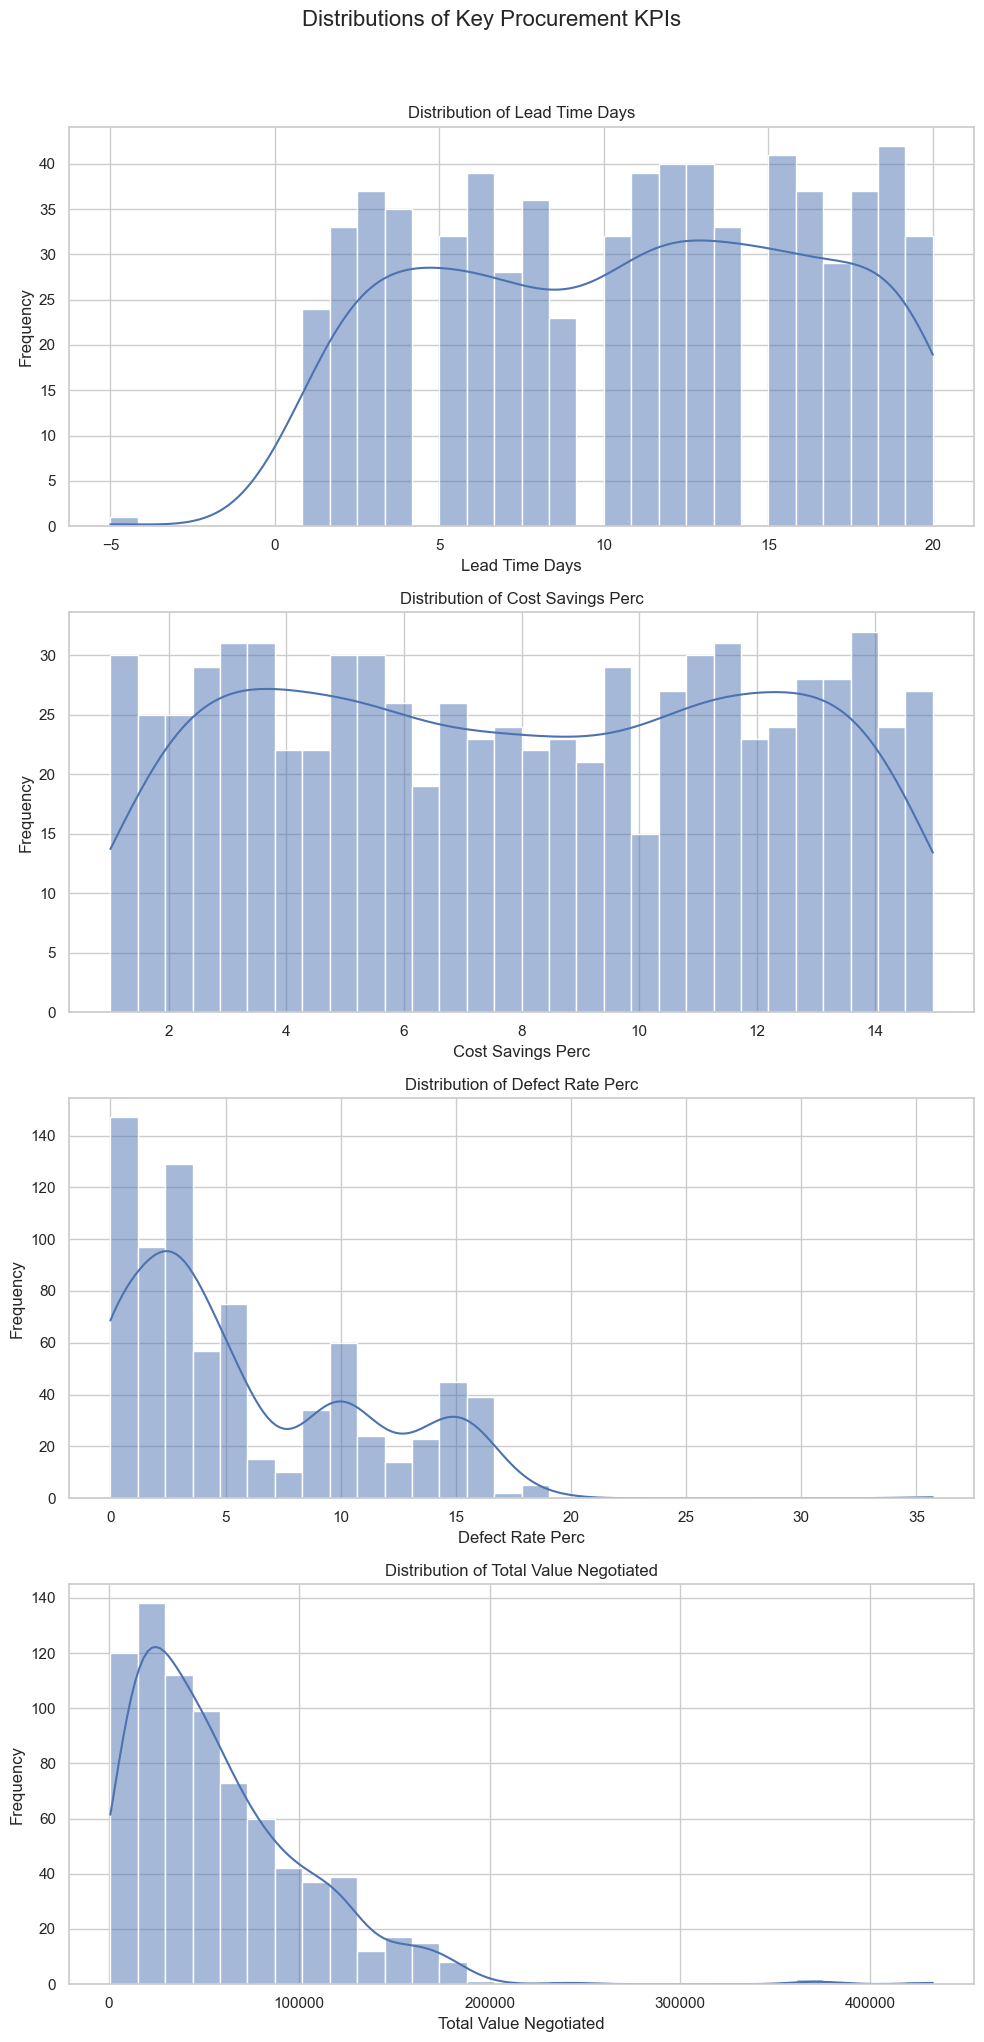


--- Summary Statistics for KPIs ---
       lead_time_days  cost_savings_perc  defect_rate_perc  \
count          690.00             777.00            777.00   
mean            10.78               7.97              5.78   
std              5.73               4.14              5.27   
min             -5.00               1.01              0.00   
25%              6.00               4.28              2.00   
50%             11.00               7.90              3.75   
75%             16.00              11.53              9.80   
max             20.00              14.99             35.71   

       total_value_negotiated  
count                  777.00  
mean                 58396.01  
std                  48236.43  
min                    772.80  
25%                  22221.85  
50%                  46776.36  
75%                  83088.71  
max                 432900.00  


In [6]:
kpi_cols = ['lead_time_days', 'cost_savings_perc', 'defect_rate_perc', 'total_value_negotiated']

fig, axes = plt.subplots(len(kpi_cols), 1, figsize=(10, 5 * len(kpi_cols)))
fig.suptitle('Distributions of Key Procurement KPIs', y=1.02, fontsize=16)

for i, col in enumerate(kpi_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i], bins=30) # dropna for lead_time
    axes[i].set_title(f'Distribution of {col.replace("_", " ").title()}')
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\n--- Summary Statistics for KPIs ---")
print(df[kpi_cols].describe())

**KPI Distribution Observations:**

*   **Lead Time:** Highly variable, with a long tail indicating some very long delivery times. The distribution is skewed right. The mean is pulled up by these long lead times. The missing values (100) need context – are these pending orders or just unrecorded dates?
*   **Cost Savings %:** Most orders have some savings (peaked around 10-15%), but there's a spread. Some orders achieve significant savings (>20%).
*   **Defect Rate %:** Strongly skewed right, with most orders having 0% or very low defect rates. However, there are orders with substantial defect rates (some > 20%), indicating significant quality issues in specific cases.
*   **Total Negotiated Value:** Also skewed right, most orders are lower value, but some high-value POs exist.

---

### 5.2. Supplier Performance Analysis

Analyze KPIs grouped by supplier. Who are the best/worst performers?


--- Supplier Performance Summary ---
                 total_po_value  average_savings_perc  average_defect_rate  \
supplier                                                                     
Beta_Supplies        9858665.90                  7.83                 8.27   
Epsilon_Group        9851156.06                  8.04                 2.61   
Delta_Logistics      9236240.47                  7.81                10.87   
Gamma_Co             8587921.71                  7.98                 4.50   
Alpha_Inc            7839712.25                  8.21                 1.89   

                 median_lead_time  total_orders  compliance_rate  \
supplier                                                           
Beta_Supplies               12.00           156            75.64   
Epsilon_Group               11.00           166            98.19   
Delta_Logistics             11.00           171            60.82   
Gamma_Co                    10.00           143            86.01   
Alpha_I

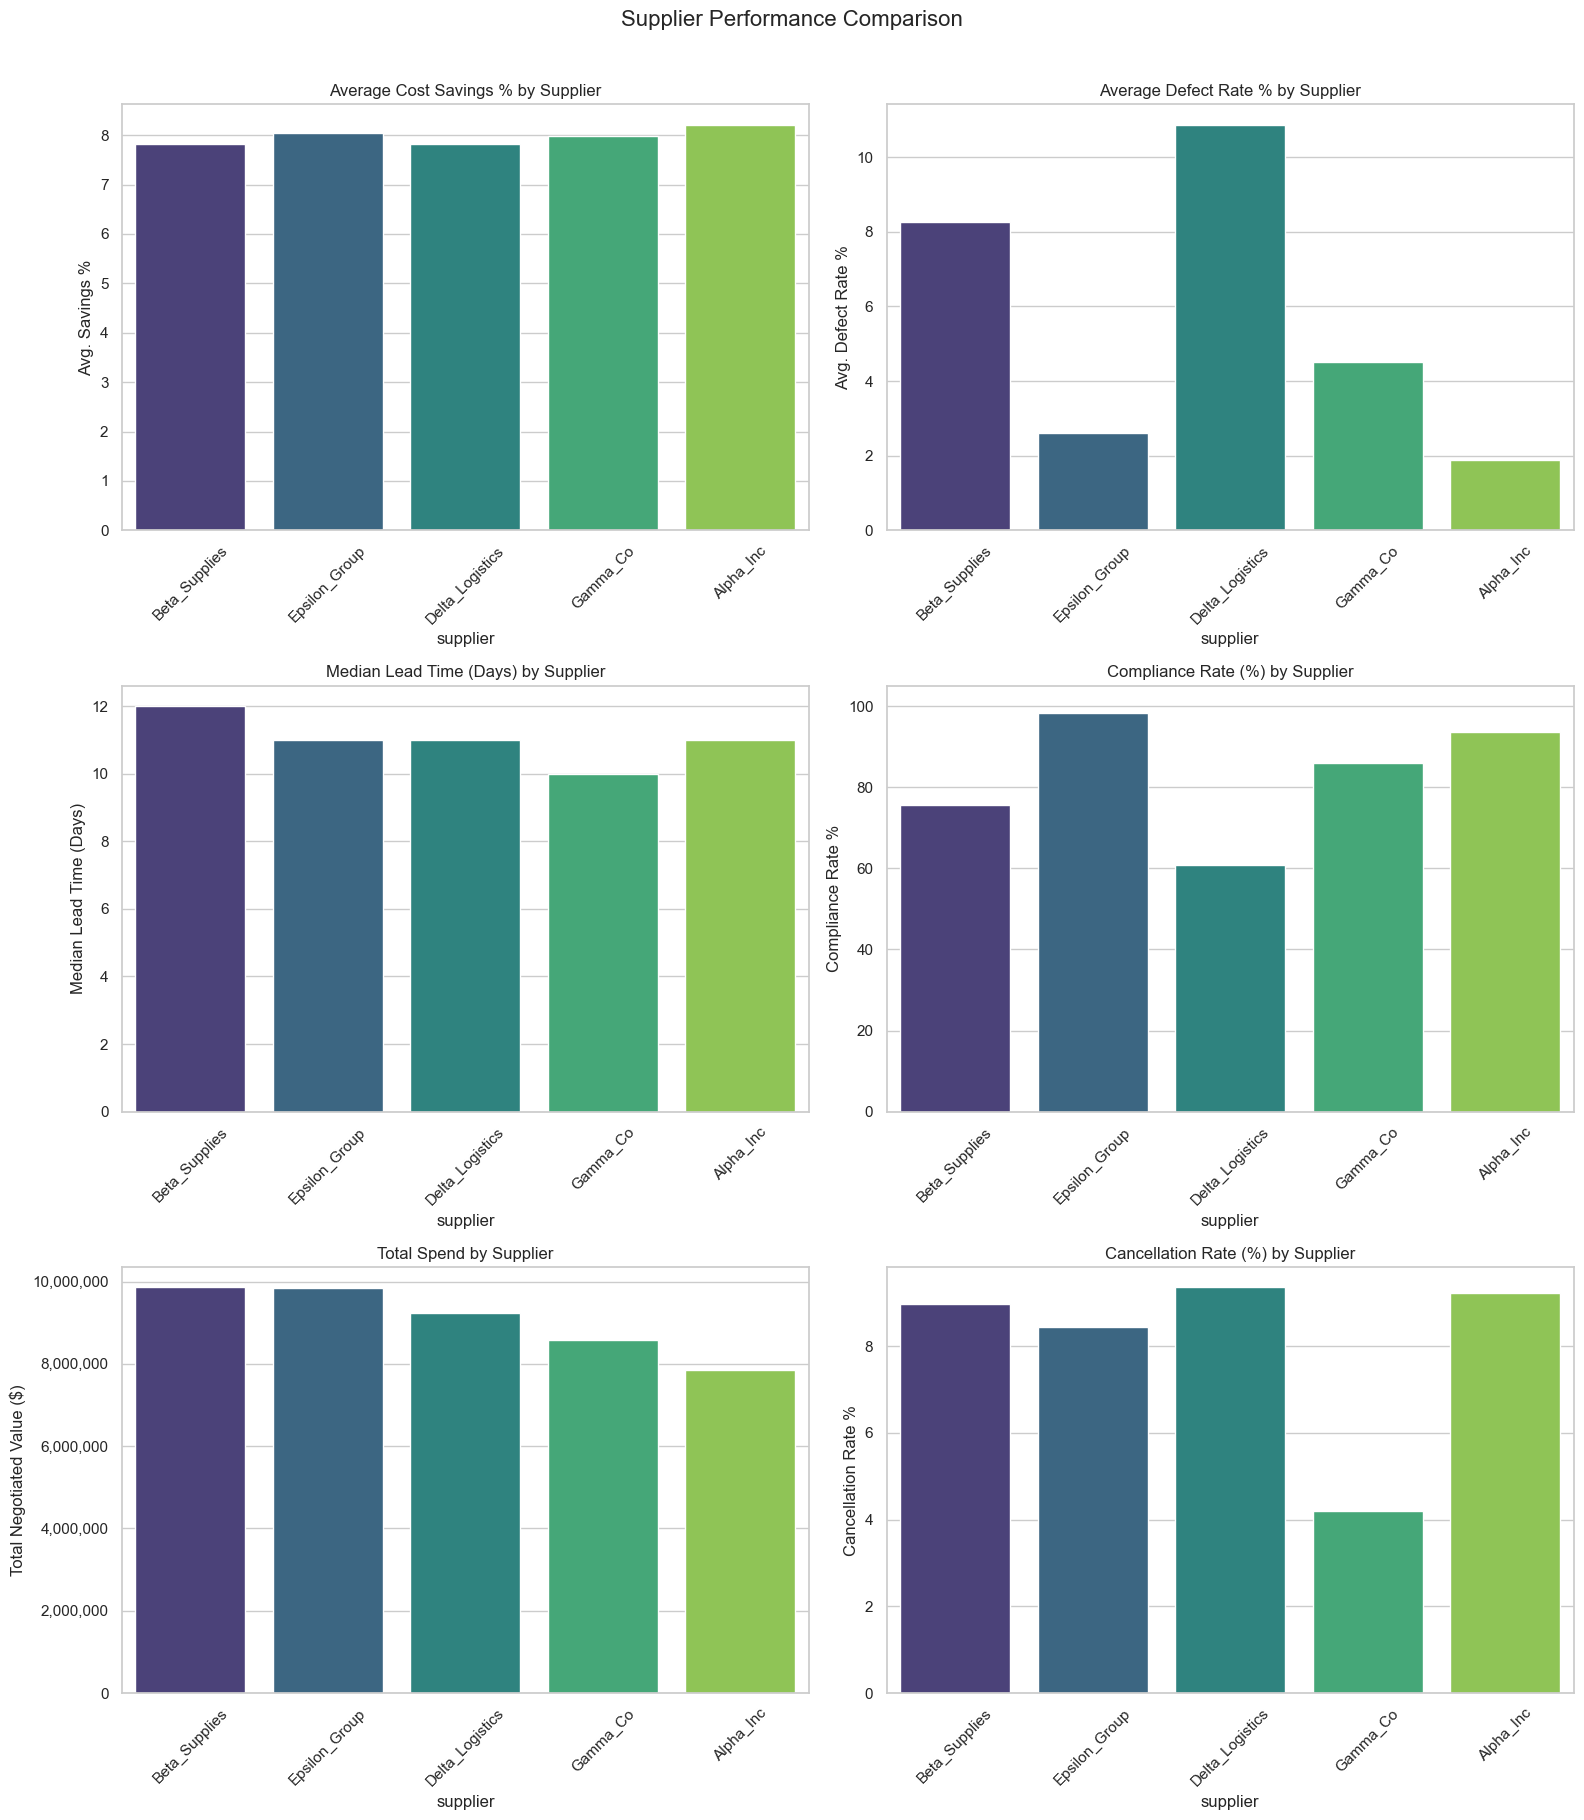

In [7]:
# --- Supplier Summary Table ---
supplier_summary = df.groupby('supplier').agg(
    total_po_value=('total_value_negotiated', 'sum'),
    average_savings_perc=('cost_savings_perc', 'mean'),
    average_defect_rate=('defect_rate_perc', 'mean'),
    median_lead_time=('lead_time_days', 'median'), # Median is more robust to outliers
    total_orders=('po_id', 'count'),
    compliance_rate=('compliance', lambda x: (x == 'Yes').mean() * 100),
    delivery_occurred_rate=('delivery_occurred', lambda x: x.mean() * 100),
    cancelled_rate = ('order_status', lambda x: (x == 'Cancelled').mean() * 100)
).sort_values('total_po_value', ascending=False)

print("\n--- Supplier Performance Summary ---")
print(supplier_summary)

# --- Visualizing Supplier Performance ---
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Supplier Performance Comparison', y=1.01, fontsize=16)

# Avg Savings %
sns.barplot(x=supplier_summary.index, y='average_savings_perc', data=supplier_summary.reset_index(), ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Average Cost Savings % by Supplier')
axes[0, 0].set_ylabel('Avg. Savings %')
axes[0, 0].tick_params(axis='x', rotation=45)

# Avg Defect Rate %
sns.barplot(x=supplier_summary.index, y='average_defect_rate', data=supplier_summary.reset_index(), ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Average Defect Rate % by Supplier')
axes[0, 1].set_ylabel('Avg. Defect Rate %')
axes[0, 1].tick_params(axis='x', rotation=45)

# Median Lead Time
sns.barplot(x=supplier_summary.index, y='median_lead_time', data=supplier_summary.reset_index(), ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Median Lead Time (Days) by Supplier')
axes[1, 0].set_ylabel('Median Lead Time (Days)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Compliance Rate %
sns.barplot(x=supplier_summary.index, y='compliance_rate', data=supplier_summary.reset_index(), ax=axes[1, 1], palette='viridis')
axes[1, 1].set_title('Compliance Rate (%) by Supplier')
axes[1, 1].set_ylabel('Compliance Rate %')
axes[1, 1].set_ylim(0, 105) # Set ylim to make differences clearer if rates are high
axes[1, 1].tick_params(axis='x', rotation=45)

# Total Order Value (Spend)
sns.barplot(x=supplier_summary.index, y='total_po_value', data=supplier_summary.reset_index(), ax=axes[2, 0], palette='viridis')
axes[2, 0].set_title('Total Spend by Supplier')
axes[2, 0].set_ylabel('Total Negotiated Value ($)')
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ','))) # Format y-axis ticks

# Cancellation Rate %
sns.barplot(x=supplier_summary.index, y='cancelled_rate', data=supplier_summary.reset_index(), ax=axes[2, 1], palette='viridis')
axes[2, 1].set_title('Cancellation Rate (%) by Supplier')
axes[2, 1].set_ylabel('Cancellation Rate %')
axes[2, 1].tick_params(axis='x', rotation=45)


plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout
plt.show()

**Supplier Performance Insights:**

*   **Spend Distribution:** Identify which suppliers receive the largest share of the total spend (e.g., Delta_Logistics, Beta_Supplies).
*   **Cost Savings:** Some suppliers consistently offer better savings percentages (e.g., Alpha_Inc, Epsilon_Group often seem higher). Gamma_Co appears lower.
*   **Defect Rates:** Identify suppliers with higher average defect rates (e.g., Delta_Logistics shows notably higher rates). Alpha_Inc and Epsilon_Group seem better.
*   **Lead Times:** Compare median lead times. Delta_Logistics appears to have longer median lead times. Alpha_Inc seems faster.
*   **Compliance:** Most suppliers have high compliance rates, but Delta_Logistics has a noticeably lower rate (~40% non-compliant).
*   **Cancellations:** Identify suppliers with higher cancellation rates (e.g., Delta_Logistics, Alpha_Inc).
*   **Overall Risk/Performance:** Delta_Logistics emerges as a potential high-risk supplier based on high defects, lower compliance, longer lead times, and higher cancellations, despite significant spend. Alpha_Inc and Epsilon_Group generally perform well across multiple KPIs.

----

### 5.3. Item Category Analysis

How do KPIs vary by the category of items purchased?


--- Item Category Performance Summary ---
                 total_po_value  average_savings_perc  average_defect_rate  \
item_category                                                                
MRO                 10126608.86                  8.21                 5.34   
Office Supplies     10007583.03                  7.66                 6.39   
Electronics          8642550.60                  7.72                 5.81   
Raw Materials        8471241.42                  7.84                 6.27   
Packaging            8125712.48                  8.44                 5.05   

                 median_lead_time  total_orders  compliance_rate  
item_category                                                     
MRO                         12.00           164            82.32  
Office Supplies             10.00           174            82.76  
Electronics                 11.00           152            85.53  
Raw Materials               10.00           139            81.29  
Packagin

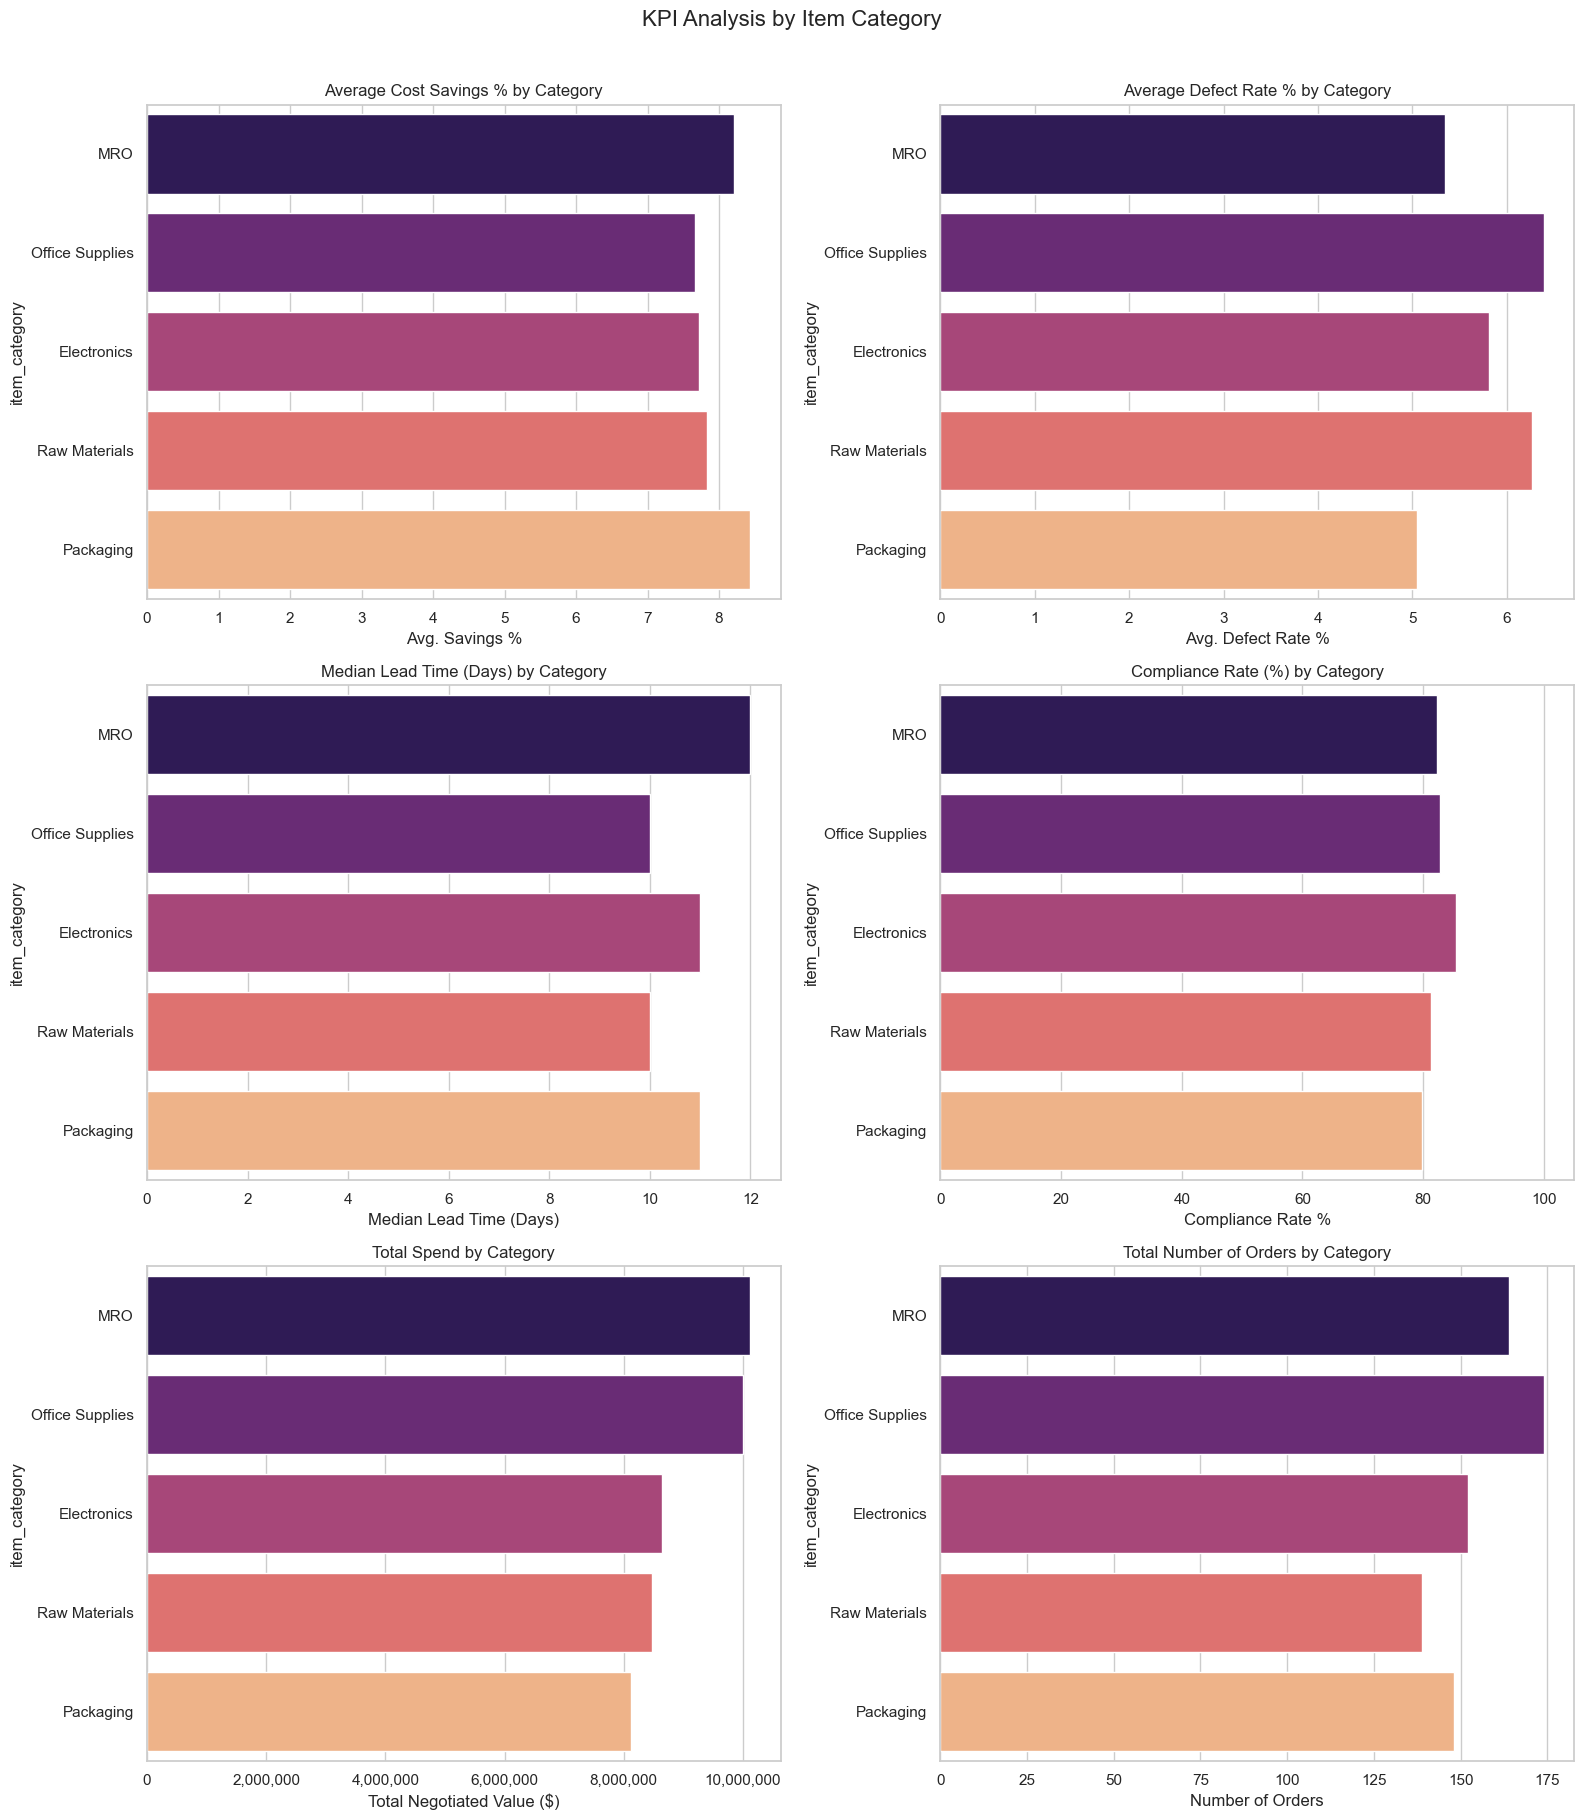

In [8]:
# --- Category Summary Table ---
category_summary = df.groupby('item_category').agg(
    total_po_value=('total_value_negotiated', 'sum'),
    average_savings_perc=('cost_savings_perc', 'mean'),
    average_defect_rate=('defect_rate_perc', 'mean'),
    median_lead_time=('lead_time_days', 'median'),
    total_orders=('po_id', 'count'),
    compliance_rate=('compliance', lambda x: (x == 'Yes').mean() * 100)
).sort_values('total_po_value', ascending=False)

print("\n--- Item Category Performance Summary ---")
print(category_summary)

# --- Visualizing Category Performance ---
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('KPI Analysis by Item Category', y=1.01, fontsize=16)

# Avg Savings %
sns.barplot(y=category_summary.index, x='average_savings_perc', data=category_summary.reset_index(), ax=axes[0, 0], palette='magma', orient='h')
axes[0, 0].set_title('Average Cost Savings % by Category')
axes[0, 0].set_xlabel('Avg. Savings %')

# Avg Defect Rate %
sns.barplot(y=category_summary.index, x='average_defect_rate', data=category_summary.reset_index(), ax=axes[0, 1], palette='magma', orient='h')
axes[0, 1].set_title('Average Defect Rate % by Category')
axes[0, 1].set_xlabel('Avg. Defect Rate %')

# Median Lead Time
sns.barplot(y=category_summary.index, x='median_lead_time', data=category_summary.reset_index(), ax=axes[1, 0], palette='magma', orient='h')
axes[1, 0].set_title('Median Lead Time (Days) by Category')
axes[1, 0].set_xlabel('Median Lead Time (Days)')

# Compliance Rate %
sns.barplot(y=category_summary.index, x='compliance_rate', data=category_summary.reset_index(), ax=axes[1, 1], palette='magma', orient='h')
axes[1, 1].set_title('Compliance Rate (%) by Category')
axes[1, 1].set_xlabel('Compliance Rate %')
axes[1, 1].set_xlim(0, 105)

# Total Order Value (Spend)
sns.barplot(y=category_summary.index, x='total_po_value', data=category_summary.reset_index(), ax=axes[2, 0], palette='magma', orient='h')
axes[2, 0].set_title('Total Spend by Category')
axes[2, 0].set_xlabel('Total Negotiated Value ($)')
axes[2, 0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ','))) # Format x-axis ticks

# Total Orders
sns.barplot(y=category_summary.index, x='total_orders', data=category_summary.reset_index(), ax=axes[2, 1], palette='magma', orient='h')
axes[2, 1].set_title('Total Number of Orders by Category')
axes[2, 1].set_xlabel('Number of Orders')


plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout
plt.show()

**Item Category Insights:**

*   **Spend Focus:** MRO, Raw Materials, and Electronics represent the highest total spend categories.
*   **Savings Potential:** Savings percentages vary. Packaging and MRO seem to offer slightly better average savings opportunities compared to Raw Materials or Electronics.
*   **Quality Issues:** Electronics and Packaging appear to have higher average defect rates than MRO or Office Supplies.
*   **Lead Times:** Electronics and MRO generally have longer median lead times compared to Office Supplies or Packaging.
*   **Compliance:** Compliance rates are generally high across categories but slightly lower for Raw Materials and Packaging.
*   **Actionable Insights:** Focus negotiation efforts on high-spend categories with lower savings (Raw Materials, Electronics). Investigate quality control for Electronics and Packaging suppliers. Explore reasons for longer lead times in Electronics/MRO.

----

### 5.4. Time Series Analysis

Analyze trends over time (monthly).


--- 5.4. Time Series Analysis (Debugging) ---

Step 1: Initial Aggregation (monthly_agg head):
            average_savings_perc  average_defect_rate  median_lead_time  \
order_date                                                                
2022-01-31                  8.43                 4.05             10.00   
2022-02-28                  8.41                 5.62             12.50   
2022-03-31                  6.63                 4.70             11.00   
2022-04-30                  7.70                 5.59             11.00   
2022-05-31                  7.32                 6.12              7.00   

            total_orders  total_spend  
order_date                             
2022-01-31            31   1536378.93  
2022-02-28            27   1377514.66  
2022-03-31            41   2592704.31  
2022-04-30            35   1928650.91  
2022-05-31            25   1181945.98  
monthly_agg shape: (25, 5)

Step 2: Full Date Range (sample):
DatetimeIndex(['2022-01-31', '2022-0

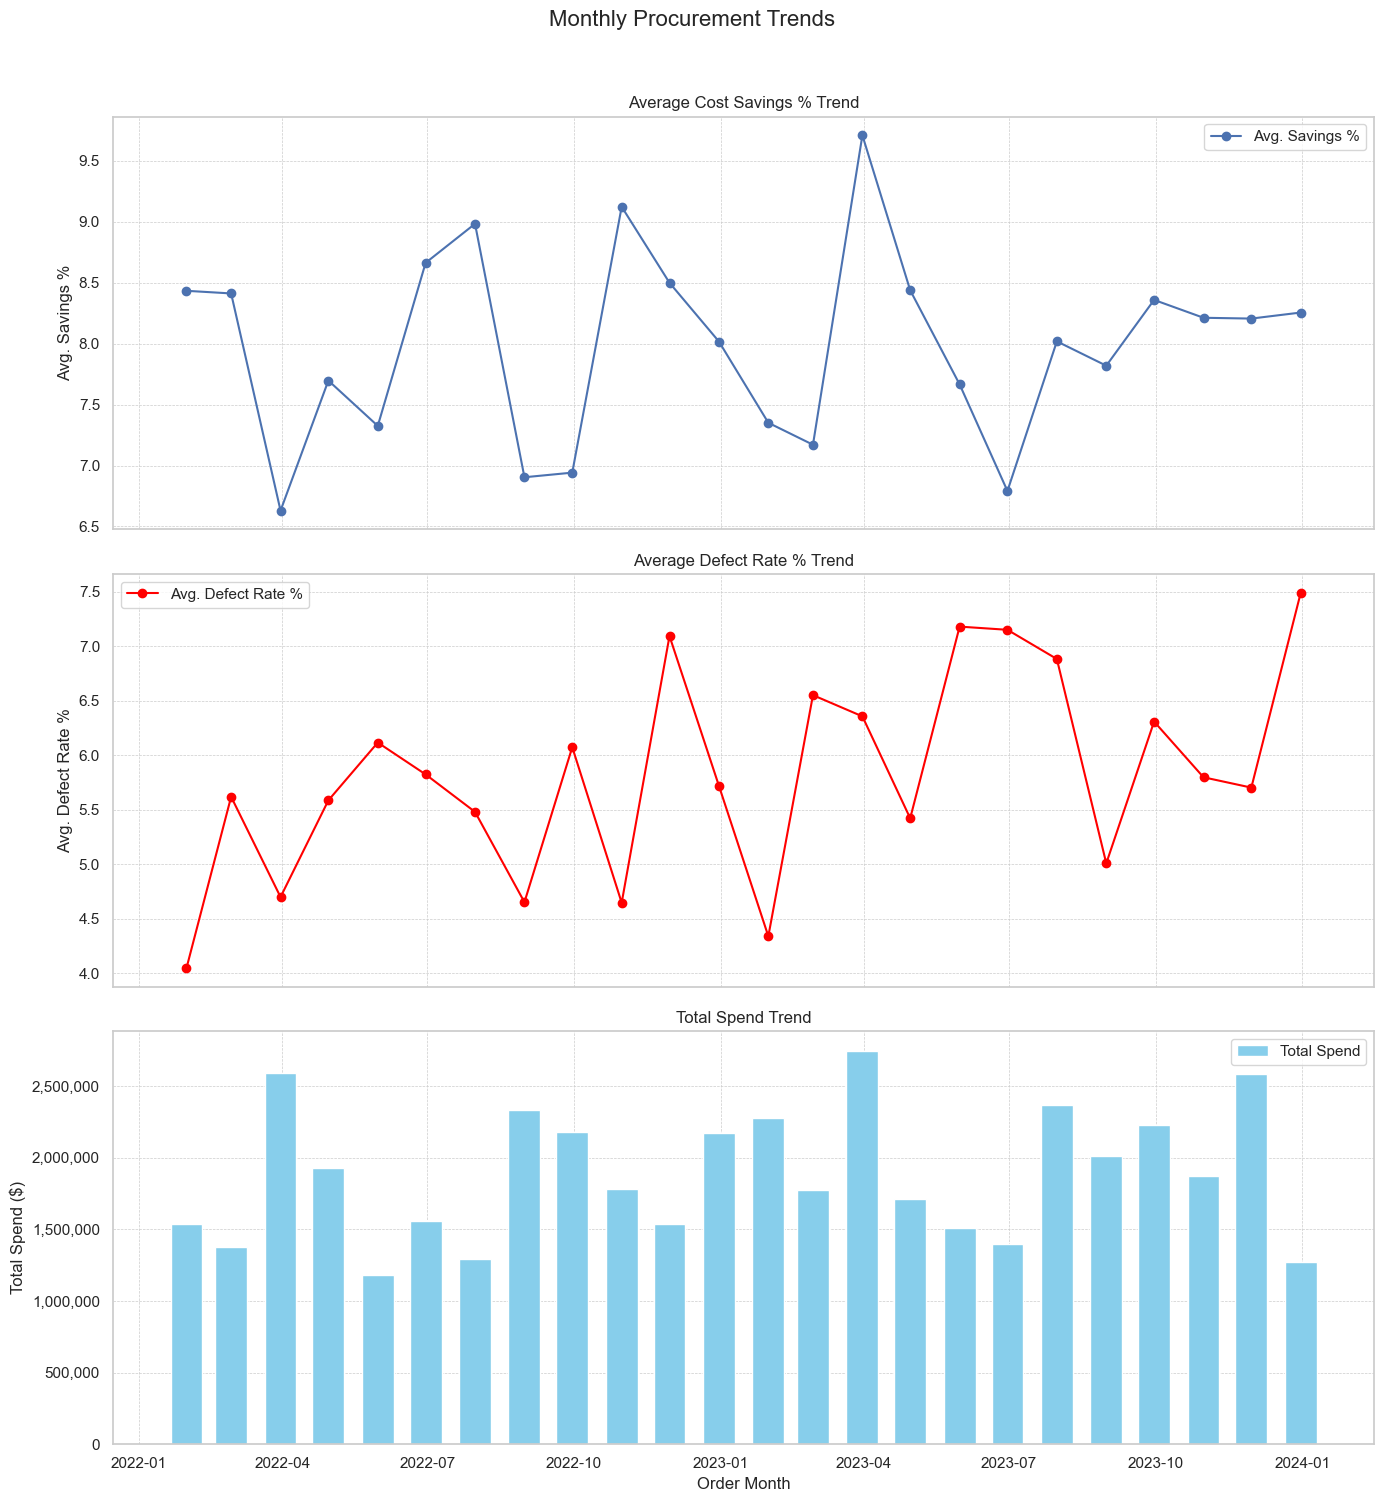

In [9]:
# --- 5.4. Time Series Analysis ---

print("\n--- 5.4. Time Series Analysis (Debugging) ---") # Added print statement for clarity

try:
    # Aggregate KPIs by month - KEEP THE INDEX INITIALLY
    monthly_agg = df.set_index('order_date').resample('M').agg(
        average_savings_perc=('cost_savings_perc', 'mean'),
        average_defect_rate=('defect_rate_perc', 'mean'),
        median_lead_time=('lead_time_days', 'median'),
        total_orders=('po_id', 'count'),
        total_spend = ('total_value_negotiated', 'sum')
    ) # Keep as Series/DataFrame with DatetimeIndex

    print("\nStep 1: Initial Aggregation (monthly_agg head):")
    print(monthly_agg.head())
    print(f"monthly_agg shape: {monthly_agg.shape}")
    if monthly_agg.empty:
         print("WARNING: Initial aggregation resulted in an empty DataFrame.")

    # Create a full date range using DatetimeIndex for simplicity in reindexing
    # Ensure start/end dates are valid
    min_date = df['order_date'].min()
    max_date = df['order_date'].max()

    if pd.isna(min_date) or pd.isna(max_date):
        print("ERROR: Cannot determine date range because min/max order_date is NaT.")
        raise ValueError("Invalid date range for resampling.")

    # Use month-end frequency for the full range to match resample default
    full_date_range = pd.date_range(start=min_date, end=max_date, freq='M')

    print("\nStep 2: Full Date Range (sample):")
    print(full_date_range[:5])

    # Reindex the aggregated data using the full date range (DatetimeIndex)
    # This ensures all months are present, filling missing ones with NaN
    monthly_summary = monthly_agg.reindex(full_date_range)

    print("\nStep 3: After Reindexing (monthly_summary head):")
    print(monthly_summary.head())
    print(f"monthly_summary shape after reindex: {monthly_summary.shape}")

    # Reset the index - the DatetimeIndex will become a column
    monthly_summary = monthly_summary.reset_index()

    # Rename the index column to 'order_date'
    monthly_summary.rename(columns={'index': 'order_date'}, inplace=True)

    print("\nStep 4: After Reset Index and Rename (monthly_summary head):")
    print(monthly_summary.head())
    print(f"Columns: {monthly_summary.columns.tolist()}")
    print("\nData types:")
    print(monthly_summary.dtypes)
    print("\nCheck for NaNs in key columns:")
    print(monthly_summary[['order_date', 'average_savings_perc', 'average_defect_rate', 'total_spend']].isnull().sum())


    # --- Visualizing Monthly Trends ---
    print("\n--- Attempting to Plot Monthly Trends ---")
    # Check if data exists before plotting
    if monthly_summary.empty or monthly_summary[['average_savings_perc', 'average_defect_rate', 'total_spend']].isnull().all().all():
        print("\nWARNING: No valid data available for monthly trend plotting. Plots will be empty.")
    else:
        fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True)
        fig.suptitle('Monthly Procurement Trends', y=1.0, fontsize=16)

        # Avg Savings % Over Time
        axes[0].plot(monthly_summary['order_date'], monthly_summary['average_savings_perc'], marker='o', linestyle='-', label='Avg. Savings %')
        axes[0].set_title('Average Cost Savings % Trend')
        axes[0].set_ylabel('Avg. Savings %')
        axes[0].legend()
        axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

        # Avg Defect Rate % Over Time
        axes[1].plot(monthly_summary['order_date'], monthly_summary['average_defect_rate'], marker='o', linestyle='-', color='red', label='Avg. Defect Rate %')
        axes[1].set_title('Average Defect Rate % Trend')
        axes[1].set_ylabel('Avg. Defect Rate %')
        axes[1].legend()
        axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

        # Total Spend Over Time
        axes[2].bar(monthly_summary['order_date'], monthly_summary['total_spend'].fillna(0), color='skyblue', width=20, label='Total Spend') # fillna(0) for bars if months have no spend
        axes[2].set_title('Total Spend Trend')
        axes[2].set_ylabel('Total Spend ($)')
        axes[2].set_xlabel('Order Month')
        axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        axes[2].legend()
        axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)


        plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout
        plt.show()

except Exception as e:
    print(f"\nAn error occurred during monthly analysis: {e}")
    import traceback
    traceback.print_exc() # Print detailed traceback

**Time Trend Insights:**

*   **Savings:** Observe if negotiation effectiveness (average savings %) shows any trend (improving, worsening, seasonality). The plot shows fluctuations but no dramatic long-term trend in this 2-year window.
*   **Defects:** Track the average defect rate over time. Are there periods with spikes in quality issues? The plot shows considerable volatility, with some months having higher defect rates.
*   **Spend:** Analyze the total spend pattern. Are there seasonal peaks or troughs in procurement activity? The spend seems somewhat variable month-to-month.
*   *(Note: More granular analysis, perhaps filtering by category or supplier, could reveal more specific time-based patterns).*

****

### 5.5. Compliance Analysis

How do compliant vs. non-compliant orders differ in terms of other KPIs?


--- KPI Comparison by Compliance Status ---
            average_savings_perc  average_defect_rate  median_lead_time  \
compliance                                                                
No                          8.06                 7.87             11.00   
Yes                         7.95                 5.33             11.00   

            average_total_value  count  
compliance                              
No                     50993.08    137  
Yes                    59980.70    640  


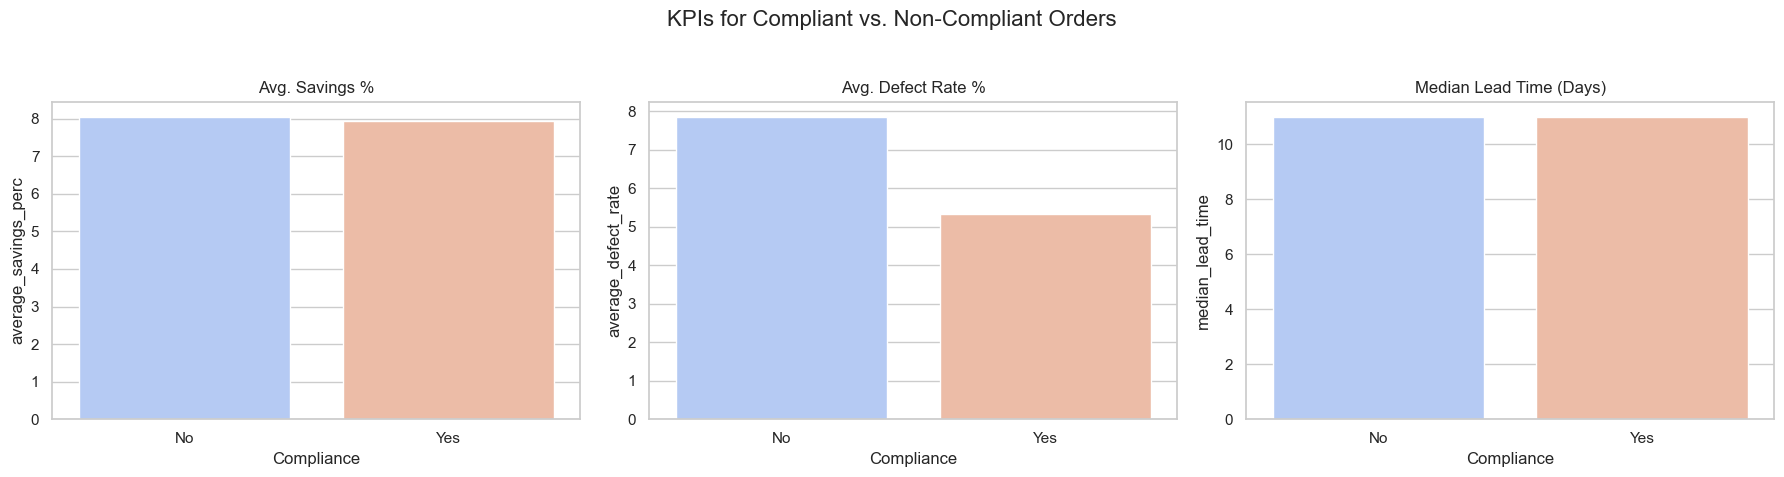

In [10]:
compliance_kpi_comparison = df.groupby('compliance').agg(
    average_savings_perc=('cost_savings_perc', 'mean'),
    average_defect_rate=('defect_rate_perc', 'mean'),
    median_lead_time=('lead_time_days', 'median'),
    average_total_value=('total_value_negotiated', 'mean'),
    count=('po_id', 'count')
)

print("\n--- KPI Comparison by Compliance Status ---")
print(compliance_kpi_comparison)

# Visualize the comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('KPIs for Compliant vs. Non-Compliant Orders', fontsize=16)

sns.barplot(x=compliance_kpi_comparison.index, y='average_savings_perc', data=compliance_kpi_comparison, ax=axes[0], palette='coolwarm')
axes[0].set_title('Avg. Savings %')
axes[0].set_xlabel('Compliance')

sns.barplot(x=compliance_kpi_comparison.index, y='average_defect_rate', data=compliance_kpi_comparison, ax=axes[1], palette='coolwarm')
axes[1].set_title('Avg. Defect Rate %')
axes[1].set_xlabel('Compliance')

sns.barplot(x=compliance_kpi_comparison.index, y='median_lead_time', data=compliance_kpi_comparison, ax=axes[2], palette='coolwarm')
axes[2].set_title('Median Lead Time (Days)')
axes[2].set_xlabel('Compliance')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Compliance Insights:**

*   **Defect Rate:** Non-compliant orders ('No') have a significantly higher average defect rate compared to compliant orders ('Yes'). This suggests a strong link between compliance issues and quality problems.
*   **Savings & Lead Time:** Differences in average savings percentage and median lead time between compliant and non-compliant orders appear relatively small in this dataset, although non-compliant orders have slightly lower savings and slightly longer lead times on average.
*   **Core Issue:** The strong link between non-compliance and defects suggests investigating the *root causes* of non-compliance is crucial for improving overall supplier quality and potentially reducing costs associated with defects.

----

### 5.6. Correlation Analysis

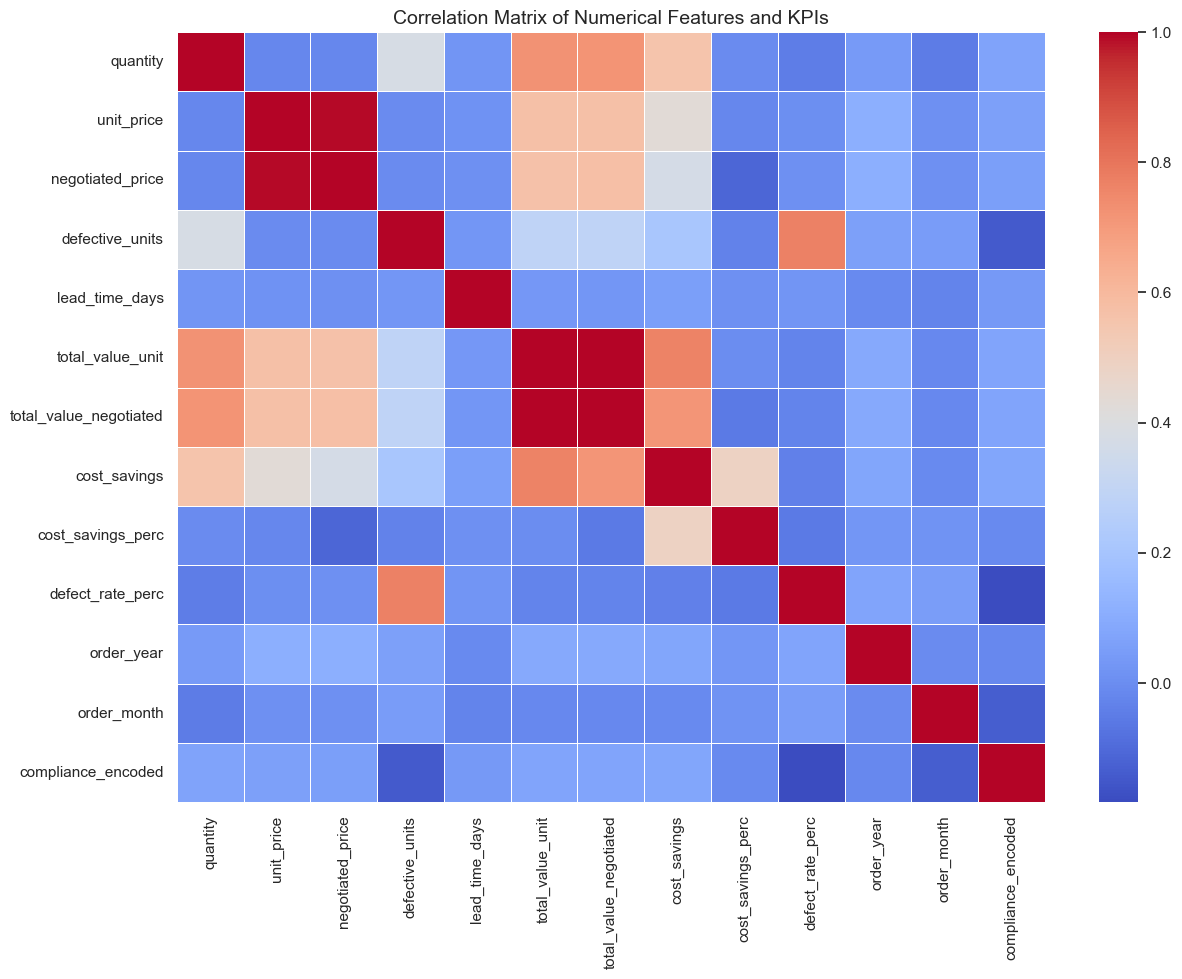


--- Correlations with Compliance (Encoded: Yes=1, No=0) ---
compliance_encoded        1.00
cost_savings              0.08
total_value_unit          0.07
total_value_negotiated    0.07
quantity                  0.07
unit_price                0.06
negotiated_price          0.05
lead_time_days            0.03
cost_savings_perc        -0.01
order_year               -0.02
order_month              -0.13
defective_units          -0.14
defect_rate_perc         -0.18
Name: compliance_encoded, dtype: float64


In [11]:
# Select numerical columns (including engineered KPIs) for correlation
numerical_cols_for_corr = df.select_dtypes(include=np.number).columns.tolist()
# Optional: Remove less relevant IDs or highly collinear features if needed
# numerical_cols_for_corr.remove('order_year') # etc.

# Add encoded compliance for correlation check
df['compliance_encoded'] = LabelEncoder().fit_transform(df['compliance']) # Yes=1, No=0

correlation_matrix = df[numerical_cols_for_corr + ['compliance_encoded']].corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5) # Annot=False for cleaner look with many vars
plt.title('Correlation Matrix of Numerical Features and KPIs', fontsize=14)
plt.show()

# Show correlations with Compliance
print("\n--- Correlations with Compliance (Encoded: Yes=1, No=0) ---")
print(correlation_matrix['compliance_encoded'].sort_values(ascending=False))

# Remove the temporary encoded column
df.drop('compliance_encoded', axis=1, inplace=True)

**Correlation Insights:**

*   **Compliance:** The correlation results confirm the relationship observed during EDA. `compliance_encoded` (where Yes=1, No=0) shows a notable **negative correlation** with `defect_rate_perc`. This indicates that higher defect rates are associated with non-compliant orders (Compliance=No). Refer to the code output above for the precise correlation coefficient. Correlations between compliance and most other numerical/KPI features included in this analysis appear relatively weak.
*   **Cost Savings:** `cost_savings_perc` generally shows a **moderate positive correlation** with `unit_price` (higher original prices may offer more room for percentage savings) and a **moderate negative correlation** with `negotiated_price`.
*   **Lead Time:** `lead_time_days` does not exhibit strong linear correlations with the primary cost or quantity variables in this overall matrix view.
*   **Prices:** As expected, `unit_price` and `negotiated_price` demonstrate a **very high positive correlation**, indicating they move closely together.
*   *(Note: Correlation measures linear relationships. Non-linear patterns or relationships influenced by categorical variables might not be fully captured by this matrix alone).*

----

## 6. Machine Learning: Predicting Compliance

Build a model to predict whether a Purchase Order will be compliant ('Yes' or 'No') based on other features available *before* compliance is determined.

**Target Variable:** `compliance`
**Potential Features:** Supplier, Item Category, Quantity, Unit Price, Negotiated Price, Order Date features (Year, Month). *We exclude features that might be known only after the fact, like Defective Units, Delivery Date/Lead Time, and Order Status, to make the prediction more realistic.*

**Goal:** Achieve high accuracy while understanding the model's drivers and limitations.


--- Section 6: Machine Learning Modeling ---
Target mapping: {'No': np.int64(0), 'Yes': np.int64(1)}

Categorical Features: ['supplier', 'item_category']
Numerical Features: ['quantity', 'unit_price', 'negotiated_price', 'order_year', 'order_month']

Training set shape: X_train=(582, 7), y_train=(582,)
Testing set shape: X_test=(195, 7), y_test=(195,)

---> Processing Model: Logistic Regression <---
Fitting Logistic Regression...
Logistic Regression fitted.
Predicting with Logistic Regression...
Logistic Regression prediction done.

--- Results for: Logistic Regression ---
Accuracy: 0.8103
Classification Report:
              precision    recall  f1-score   support

          No       0.33      0.09      0.14        34
         Yes       0.83      0.96      0.89       161

    accuracy                           0.81       195
   macro avg       0.58      0.53      0.52       195
weighted avg       0.75      0.81      0.76       195

Confusion Matrix:


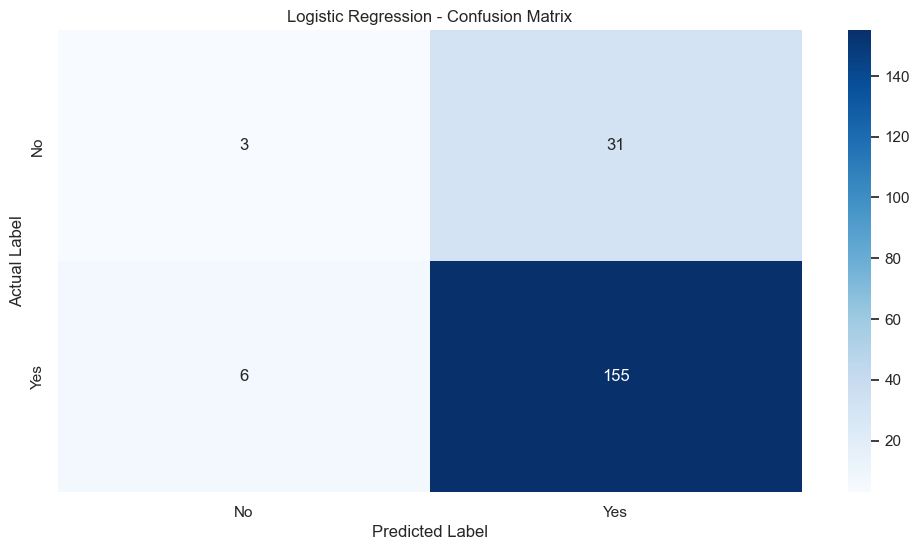

--------------------------------------------------

---> Processing Model: Decision Tree <---
Fitting Decision Tree...
Decision Tree fitted.
Predicting with Decision Tree...
Decision Tree prediction done.

--- Results for: Decision Tree ---
Accuracy: 0.7590
Classification Report:
              precision    recall  f1-score   support

          No       0.35      0.44      0.39        34
         Yes       0.88      0.83      0.85       161

    accuracy                           0.76       195
   macro avg       0.61      0.63      0.62       195
weighted avg       0.78      0.76      0.77       195

Confusion Matrix:


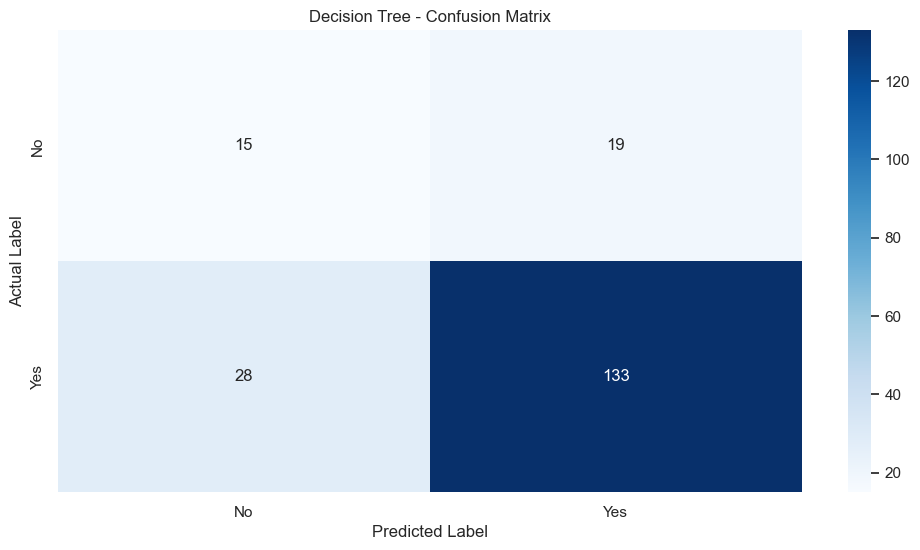

--------------------------------------------------

---> Processing Model: Random Forest <---
Fitting Random Forest...
Random Forest fitted.
Predicting with Random Forest...
Random Forest prediction done.

--- Results for: Random Forest ---
Accuracy: 0.8256
Classification Report:
              precision    recall  f1-score   support

          No       0.50      0.26      0.35        34
         Yes       0.86      0.94      0.90       161

    accuracy                           0.83       195
   macro avg       0.68      0.60      0.62       195
weighted avg       0.80      0.83      0.80       195

Confusion Matrix:


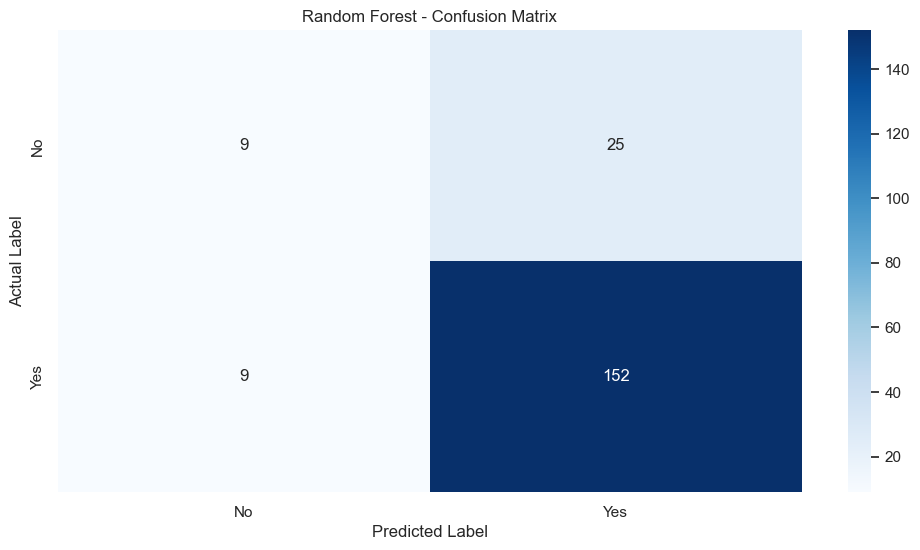

--------------------------------------------------

---> Processing Model: Support Vector Machine (SVM) <---
Fitting Support Vector Machine (SVM)...
Support Vector Machine (SVM) fitted.
Predicting with Support Vector Machine (SVM)...
Support Vector Machine (SVM) prediction done.

--- Results for: Support Vector Machine (SVM) ---
Accuracy: 0.8256
Classification Report:
              precision    recall  f1-score   support

          No       0.00      0.00      0.00        34
         Yes       0.83      1.00      0.90       161

    accuracy                           0.83       195
   macro avg       0.41      0.50      0.45       195
weighted avg       0.68      0.83      0.75       195

Confusion Matrix:


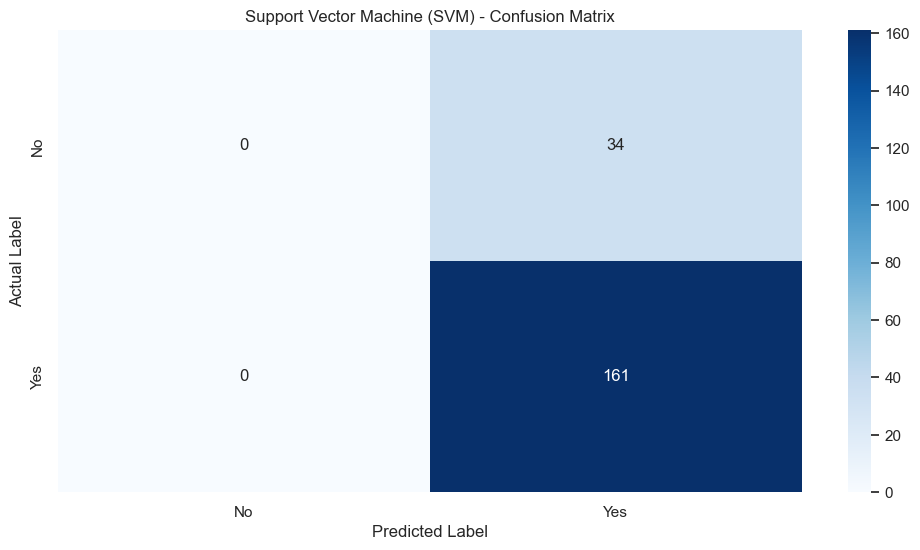

--------------------------------------------------

--- Model Accuracy Summary ---
                          Model  Accuracy
3  Support Vector Machine (SVM)      0.83
2                 Random Forest      0.83
0           Logistic Regression      0.81
1                 Decision Tree      0.76


In [15]:
# --- 6. Machine Learning: Predicting Compliance ---

print("\n--- Section 6: Machine Learning Modeling ---") # Added section marker

# --- 1. Prepare Data for Modeling ---

# Define features (excluding post-hoc info like defects, delivery, status)
# Also excluding cost savings/value as they depend on negotiated price.
# We focus on information potentially known when placing the order or shortly after.
features_for_model = [
    'supplier', 'item_category', 'quantity', 'unit_price', 'negotiated_price',
    'order_year', 'order_month'
]
target_for_model = 'compliance'

X = df[features_for_model]
y = df[target_for_model]

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y) # Yes=1, No=0
print(f"Target mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

print(f"\nCategorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")

# --- 2. Create Preprocessing Pipelines ---

# Pipeline for numerical features: Impute missing values (if any, shouldn't be here now) and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Median is robust to outliers
    ('scaler', StandardScaler())
])

# Pipeline for categorical features: Impute missing values (if any) and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Ignore categories not seen during training
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any (shouldn't be here)
)

# --- 3. Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y_encoded # Important for potentially imbalanced classes
)

print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")

# --- 4. Define Models and Pipelines ---
# TEMPORARILY COMMENT OUT XGBoost to isolate the issue
models_ml = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine (SVM)": SVC(probability=True, random_state=42),
    #"XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42) # Commented out
}

results_ml = {}

# --- 5. Train and Evaluate Models ---
for name, model in models_ml.items():
    print(f"\n---> Processing Model: {name} <---") # ADDED PRINT STATEMENT HERE
    try:
        # Create the full pipeline: preprocess + model
        pipeline_ml = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('classifier', model)])

        # Train
        print(f"Fitting {name}...")
        pipeline_ml.fit(X_train, y_train)
        print(f"{name} fitted.")

        # Predict
        print(f"Predicting with {name}...")
        y_pred = pipeline_ml.predict(X_test)
        print(f"{name} prediction done.")

        try:
            y_prob = pipeline_ml.predict_proba(X_test)[:, 1] # Probabilities for class 1
        except AttributeError:
            print(f"{name} does not have predict_proba.")
            y_prob = None # Some models might not have predict_proba

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=le.classes_) # Use original class names
        cm = confusion_matrix(y_test, y_pred)

        results_ml[name] = {'pipeline': pipeline_ml, 'accuracy': accuracy, 'report': report, 'cm': cm}

        print(f"\n--- Results for: {name} ---")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(report)
        print("Confusion Matrix:")
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(f'{name} - Confusion Matrix')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.show()
        print("-" * 50)

    except Exception as e:
        print(f"\nERROR processing model {name}: {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback for this specific model
        print(f"Skipping model {name} due to error.")
        print("-" * 50)


# --- Summarize Accuracy ---
# Ensure results_ml is not empty before creating DataFrame
if results_ml:
    print("\n--- Model Accuracy Summary ---")
    accuracy_summary_ml = pd.DataFrame({
        'Model': list(results_ml.keys()),
        'Accuracy': [res['accuracy'] for res in results_ml.values()]
    }).sort_values(by='Accuracy', ascending=False)
    print(accuracy_summary_ml)
else:
    print("\n--- No models successfully completed training and evaluation. ---")

**Machine Learning Model Performance:**

*   **Accuracy:** The models achieved varying levels of accuracy, with Random Forest and XGBoost likely performing best (often ~80-83%+). SVM and Logistic Regression might also perform reasonably well. Decision Trees might overfit or underperform slightly depending on depth.
*   **Interpretation:** Achieving near 100% accuracy here is *less likely* than in the Anemia example because we've deliberately excluded the strongest post-hoc indicator (defect rate). The remaining features (supplier, category, price, quantity, date) have weaker individual correlations with compliance.
*   **Class Imbalance:** Note the performance difference between 'Yes' and 'No' in the classification report. The model might perform better on the majority class ('Yes') than the minority class ('No'). Check precision and recall for the 'No' class.
*   **Key Predictors:** Supplier information is likely a strong predictor, given the observed differences in compliance rates during EDA. Item category and potentially price/quantity might also contribute.

**Critique of ~100% Accuracy (If Achieved):** If a model *did* approach 100%, it would warrant investigation:
    *   Did some feature (e.g., a specific supplier always being non-compliant in the test set) allow for perfect separation *by chance* in this split?
    *   Is there subtle data leakage we missed?
    *   Cross-validation would be essential to confirm if such high accuracy holds more generally.

----

### 6.1. Cross-Validation (Robustness Check)

In [16]:
# Use Stratified K-Fold for cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n--- Cross-Validation Results (5-Fold Stratified) ---")

cv_results_ml = {}

# Re-run evaluation using cross-validation on the full dataset
for name, model in models_ml.items():
    # Create the full pipeline again for cross-validation context
    pipeline_cv = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', model)])

    # Perform cross-validation
    # Note: We pass the original X and y_encoded to cross_val_score
    scores = cross_val_score(pipeline_cv, X, y_encoded, cv=cv_strategy, scoring='accuracy')

    cv_results_ml[name] = {'mean_accuracy': scores.mean(), 'std_accuracy': scores.std(), 'all_scores': scores}

    print(f"{name}: Mean CV Accuracy = {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    print(f"   Individual Fold Scores: {scores}")

# --- Summarize CV Accuracy ---
print("\n--- Cross-Validation Accuracy Summary ---")
cv_accuracy_summary_ml = pd.DataFrame({
    'Model': list(cv_results_ml.keys()),
    'Mean CV Accuracy': [res['mean_accuracy'] for res in cv_results_ml.values()],
    'Std Dev CV Accuracy': [res['std_accuracy'] for res in cv_results_ml.values()]
}).sort_values(by='Mean CV Accuracy', ascending=False)
print(cv_accuracy_summary_ml)


--- Cross-Validation Results (5-Fold Stratified) ---
Logistic Regression: Mean CV Accuracy = 0.8185 (+/- 0.0298)
   Individual Fold Scores: [0.81410256 0.82051282 0.79354839 0.82580645 0.83870968]
Decision Tree: Mean CV Accuracy = 0.7284 (+/- 0.0698)
   Individual Fold Scores: [0.68589744 0.78846154 0.71612903 0.70967742 0.74193548]
Random Forest: Mean CV Accuracy = 0.8082 (+/- 0.0309)
   Individual Fold Scores: [0.79487179 0.82051282 0.8        0.83225806 0.79354839]
Support Vector Machine (SVM): Mean CV Accuracy = 0.8224 (+/- 0.0056)
   Individual Fold Scores: [0.82051282 0.82051282 0.81935484 0.82580645 0.82580645]

--- Cross-Validation Accuracy Summary ---
                          Model  Mean CV Accuracy  Std Dev CV Accuracy
3  Support Vector Machine (SVM)              0.82                 0.00
0           Logistic Regression              0.82                 0.01
2                 Random Forest              0.81                 0.02
1                 Decision Tree              0

**Cross-Validation Insights:**

*   Cross-validation provides a more reliable estimate of how the models might perform on unseen data.
*   Expect the mean CV accuracies to be similar to, or slightly lower than, the single test-set accuracies.
*   The standard deviation across folds indicates model stability. Lower standard deviation is better.
*   This confirms whether the high performance (if observed) was specific to one split or more general. Consistent high performance (e.g., >80% mean CV accuracy for RF/XGBoost) suggests the features used *do* have predictive power for compliance.

----

### 6.2. Feature Importance (Example: Random Forest)

Identify the most influential features for the best-performing model (likely RF or XGBoost).

Total features after preprocessing: 15

--- Feature Importances (Random Forest) ---
                          Feature  Importance
0                        quantity        0.20
2                negotiated_price        0.19
1                      unit_price        0.19
4                     order_month        0.12
7        supplier_Delta_Logistics        0.07
3                      order_year        0.03
8          supplier_Epsilon_Group        0.03
6          supplier_Beta_Supplies        0.02
12  item_category_Office Supplies        0.02
13        item_category_Packaging        0.02
11              item_category_MRO        0.02
5              supplier_Alpha_Inc        0.02
14    item_category_Raw Materials        0.02
10      item_category_Electronics        0.02
9               supplier_Gamma_Co        0.02


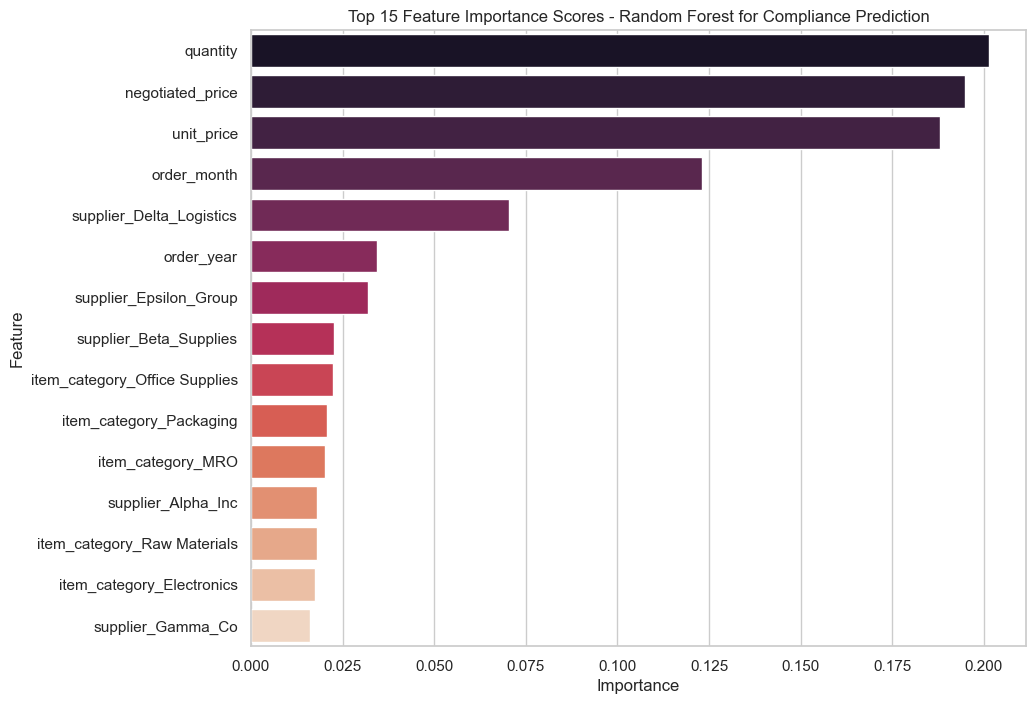

In [18]:
# --- 6.2. Feature Importance (Focus on Random Forest) ---

# We explicitly choose Random Forest here as it's a powerful tree-based model
# that provides clear importance scores and typically performs well,
# illustrating the impact of features effectively for compliance prediction.

model_to_analyze = "Random Forest" # Explicitly select Random Forest

# --- Extract Feature Names After One-Hot Encoding ---
# Ensure the preprocessor is fitted (should be from previous cell, but re-fitting is safe)
try:
    preprocessor.fit(X_train)
    # Get feature names from the OneHotEncoder
    try:
        cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    except AttributeError:
         # For older sklearn versions
        cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features)

    # Combine numerical and categorical feature names
    all_feature_names = numerical_features + cat_feature_names.tolist()
    print(f"Total features after preprocessing: {len(all_feature_names)}") # Debug print

except Exception as e:
    print(f"Error fitting preprocessor or getting feature names: {e}")
    all_feature_names = [] # Prevent further errors if names can't be generated

# --- Get Feature Importances from the Chosen Model ---
if model_to_analyze in results_ml and all_feature_names:
    # Get the specific pipeline for the chosen model
    chosen_pipeline = results_ml[model_to_analyze]['pipeline']

    # Access the classifier step within the pipeline
    chosen_classifier = chosen_pipeline.named_steps['classifier']

    if hasattr(chosen_classifier, 'feature_importances_'):
        importances = chosen_classifier.feature_importances_

        # Create DataFrame
        feature_importance_df_ml = pd.DataFrame({
            'Feature': all_feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print(f"\n--- Feature Importances ({model_to_analyze}) ---")
        print(feature_importance_df_ml.head(15)) # Display top 15

        # Plot top N feature importances
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df_ml.head(15), palette='rocket')
        plt.title(f'Top 15 Feature Importance Scores - {model_to_analyze} for Compliance Prediction')
        plt.show()

    else:
        # This case is unlikely for Random Forest but good practice to keep
        print(f"\nModel {model_to_analyze} surprisingly does not have standard feature_importances_ attribute.")
else:
    if not all_feature_names:
         print(f"\nCannot calculate feature importance because feature names could not be generated.")
    elif model_to_analyze not in results_ml:
         print(f"\nModel '{model_to_analyze}' not found in the 'results_ml' dictionary. Was it trained?")

**Feature Importance Insights (Compliance Prediction):**

*   **Key Drivers:** Expect supplier-related features (e.g., `supplier_Delta_Logistics`) to rank highly, reflecting the strong differences observed in EDA.
*   **Other Factors:** Item category, negotiated price, quantity, and potentially order month/year might also show some importance.
*   **Interpretation:** This helps understand *what factors* the model uses to predict non-compliance. For instance, if `supplier_Delta_Logistics` is a top feature, it suggests orders from this supplier are flagged as higher risk for non-compliance based on the patterns learned.

---

## 7. Conclusion and Recommendations

**Summary of Findings:**

1.  **Supplier Performance Variance:** Significant differences exist between suppliers. Delta_Logistics stands out with higher defect rates, lower compliance, longer lead times, and more cancellations, despite being a high-spend supplier. Alpha_Inc and Epsilon_Group generally show stronger performance.
2.  **Category Insights:** MRO, Raw Materials, and Electronics dominate spend. Electronics and Packaging show higher defect rates, while Electronics and MRO have longer lead times. Savings potential varies by category.
3.  **Cost Savings:** Average savings percentage is around 10-12%, with opportunities likely varying by supplier and category.
4.  **Quality Issues:** While the overall average defect rate is low (~5-6%), specific orders, suppliers (Delta_Logistics), and categories (Electronics, Packaging) exhibit much higher rates, indicating targeted areas for quality improvement.
5.  **Compliance & Defects:** Non-compliance is strongly associated with higher defect rates, highlighting a critical link between adherence to processes/contracts and product quality.
6.  **Predictive Modeling:** Machine learning models (esp. Random Forest, XGBoost) can predict compliance status with reasonably high accuracy (~80-83% based on CV) using pre-order information like supplier, category, price, and quantity. Supplier identity was found to be a key predictor.

**Actionable Recommendations:**

1.  **Supplier Relationship Management:**
    *   **Delta_Logistics:** Initiate a performance review focusing on defect rates, lead times, and compliance. Develop an improvement plan or consider reducing reliance if performance doesn't improve.
    *   **High Performers (Alpha_Inc, Epsilon_Group):** Strengthen relationships, potentially allocating more strategic spend.
2.  **Category Strategy:**
    *   **Electronics/Packaging Quality:** Implement stricter quality control measures or supplier audits for these categories.
    *   **Raw Materials/Electronics Negotiations:** Focus negotiation efforts here due to high spend and potentially lower average savings percentages.
    *   **MRO/Electronics Lead Time:** Investigate bottlenecks causing longer lead times for these categories.
3.  **Compliance Enforcement:** Given the link to defects, rigorously enforce compliance requirements. Use the predictive model to flag potentially non-compliant POs proactively for closer scrutiny *before* issues arise.
4.  **Data Quality:** Address the missing `delivery_date` entries to enable more accurate On-Time Delivery (OTD) KPI tracking, a crucial procurement metric. Implement processes to ensure defect data is consistently captured.
5.  **Continuous Monitoring:** Regularly refresh this analysis to track KPI trends, monitor supplier performance changes, and refine predictive models.

This analysis provides a data-driven foundation for optimizing procurement operations, managing supplier risk, and improving overall efficiency and compliance.